In [111]:
import nilearn

from medpy.io import load
from medpy.features.intensity import intensities
from nilearn import image
import nibabel as nib
from medpy.io import header
from medpy.io import load, save
import copy
from nilearn import plotting
import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
from math import ceil
from nilearn.datasets import MNI152_FILE_PATH
from sklearn.model_selection import train_test_split
from nibabel.affines import apply_affine
from nilearn.image.resampling import coord_transform, get_bounds, get_mask_bounds
from nilearn.image import resample_img
from nilearn.masking import compute_background_mask
import pyten
from pyten.tenclass import Tensor  # Use it to construct Tensor object
from pyten.tools import tenerror
from pyten.method import *
from datetime import datetime
import file_service as fs
import csv
from collections import OrderedDict

import mri_draw_utils as mrd

import configparser
import tensor_util as tu
import pandas as pd
import mri_draw_utils as mrd
import metric_util as mt
import data_util as du
import cost_computation as cst
from nilearn.masking import compute_epi_mask
%matplotlib inline
import matplotlib.pyplot as plt



In [112]:
import numpy as np
from numpy.linalg import inv as inv
import numpy.linalg as ng
import time

In [113]:
def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

In [114]:
def mat2ten(mat, tensor_size, mode):
    index = list()
    index.append(mode)
    for i in range(tensor_size.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(tensor_size[index]), order = 'F'), 0, mode)

In [115]:
def svt(mat, lambda0): ## Singular value thresholding (SVT)
    u, s, v = np.linalg.svd(mat, full_matrices = 0)
    vec = s - lambda0
    vec[np.where(vec < 0)] = 0
    
    return np.matmul(np.matmul(u, np.diag(vec)), v)

In [178]:
def HaLRTC(dense_tensor, sparse_tensor, mask, alpha, rho, maxiter):
    
    dim0 = sparse_tensor.ndim
    dim1, dim2, dim3 = sparse_tensor.shape
    position = np.where(mask !=0.0)
    binary_tensor = mask.copy()
    tensor_hat = sparse_tensor.copy()
    
    Z = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{Z}} (n1*n2*3*d)
    T = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{T}} (n1*n2*3*d)
    
    rse = mt.relative_error(tensor_hat,dense_tensor)
    print ("Iteration Count = " +  "; RSE M 1= " + str(rse))
    for iters in range(maxiter):
        for k in range(dim0):
            Z[:, :, :, k] = mat2ten(svt(ten2mat(tensor_hat + T[:, :, :, k] / rho, k), 
                                        alpha / rho), np.array([dim1, dim2, dim3]), k)
        rse = mt.relative_error(tensor_hat,dense_tensor)
        print ("Iteration Count = " + str(iters) + "; RSE M= " + str(rse))
        tensor_hat = np.mean(Z - T / rho, axis = 3)
        tensor_hat[position] = sparse_tensor[position]
        for k in range(dim0):
            T[:, :, :, k] = T[:, :, :, k] + rho * (tensor_hat - Z[:, :, :, k])
        
        print ("Iteration Count = " + str(iters) + "; RSE = " + str(rse))

    return tensor_hat

In [104]:
def get_mask_with_epi3D(x, x_img, observed_ratio,d):
    mask_img = compute_epi_mask(x_img)
    mask_img_data = np.array(mask_img.get_data())
    
    epi_mask = copy.deepcopy(mask_img_data)
    
    if d==3:
        mask_indices = tu.get_mask3D(x, observed_ratio)
    else:
        mask_indices = tu.get_mask4D(x, observed_ratio)
    
    mask_indices[epi_mask==0] = 1
   
    epi_mask = copy.deepcopy(mask_img_data)
  
    return mask_indices

In [116]:
d=3
observed_ratio = 0.9
subject_scan_path = du.get_full_path_subject1()
x_true_img = mt.read_image_abs_path(subject_scan_path)
x_true_data = np.array(x_true_img.get_data())
x_true_reshaped = copy.deepcopy(x_true_data)
x_true_copy = copy.deepcopy(x_true_data)              
target_shape = mt.get_target_shape(x_true_data, d)
x_true_reshaped_rank = mt.reshape_as_nD(x_true_copy,d,target_shape)
        
tensor_shape = tu.get_tensor_shape(x_true_data)
max_tt_rank = tu.get_max_rank(x_true_reshaped_rank)

num_rows = target_shape[0]
x_reshaped = np.reshape(x_true_data, (num_rows,target_shape[1], target_shape[2])) 

mask_indices = tu.get_mask_with_epi(x_true_data, x_true_img, observed_ratio, d)
mask_indices = np.reshape(mask_indices, (num_rows,target_shape[1], target_shape[2])) 

#init after reshape
ten_ones = tu.get_ten_ones(x_true_reshaped_rank)
       
# ground truth to be initialized later after reshape
ground_truth, norm_ground_truth = tu.normalize_data(x_true_reshaped_rank)                
ground_truth_img = mt.reconstruct_image_affine(x_true_img, ground_truth)
sparse_observation = tu.create_sparse_observation(ground_truth, mask_indices)
sparse_observation[mask_indices == 0] = 0.0
x_miss_img = mt.reconstruct_image_affine_d(x_true_img, sparse_observation, d, x_true_data.shape)
        
x_init = tu.init_random(x_true_reshaped) 
x_init_tcs = ground_truth * (1./np.linalg.norm(x_init))
x_init, norm_x_init = tu.normalize_data(x_init)


Reshape Required. D = 3; Target Shape: (3339, 46, 144)
Resulted Target Shape: (3339, 46, 144)


In [2]:
subject_scan_path = du.get_full_path_subject1()

In [179]:
num_rows = target_shape[0]
x_reshaped = np.reshape(ground_truth, (num_rows,target_shape[1], target_shape[2])) 
sparse_reshaped = np.reshape(sparse_observation, (num_rows,target_shape[1], target_shape[2])) 
ground_truth_reshaped = np.reshape(ground_truth, (num_rows,target_shape[1], target_shape[2])) 
mask_indices_reshaped = np.reshape(mask_indices, (num_rows,target_shape[1], target_shape[2])) 

In [42]:
sparse_reshaped.shape

(3339, 46, 144)

In [213]:
alpha = 1
rho = 0.01
maxiter = 10
start = time.time()
image_hat = HaLRTC(ground_truth, sparse_observation, mask_indices, alpha, rho, maxiter)
end = time.time()

Iteration Count = ; RSE M 1= 0.30188563
Iteration Count = 0; RSE M= 0.30188563
Iteration Count = 0; RSE = 0.30188563
Iteration Count = 1; RSE M= 0.301885607171598
Iteration Count = 1; RSE = 0.301885607171598
Iteration Count = 2; RSE M= 0.301885607171598
Iteration Count = 2; RSE = 0.301885607171598
Iteration Count = 3; RSE M= 0.301885607171598
Iteration Count = 3; RSE = 0.301885607171598
Iteration Count = 4; RSE M= 0.301885607171598
Iteration Count = 4; RSE = 0.301885607171598
Iteration Count = 5; RSE M= 0.301885607171598
Iteration Count = 5; RSE = 0.301885607171598
Iteration Count = 6; RSE M= 0.301885607171598
Iteration Count = 6; RSE = 0.301885607171598
Iteration Count = 7; RSE M= 0.301885607171598
Iteration Count = 7; RSE = 0.301885607171598
Iteration Count = 8; RSE M= 0.301885607171598
Iteration Count = 8; RSE = 0.301885607171598
Iteration Count = 9; RSE M= 0.301885607171598
Iteration Count = 9; RSE = 0.301885607171598


In [214]:
rse = mt.relative_error(image_hat,ground_truth_reshaped)

In [215]:
rse

0.301885607171598

In [123]:
ten_ones = np.ones_like(ground_truth)

In [216]:
tsc_score_new = cst.tsc(image_hat,ground_truth, ten_ones, mask_indices)

In [217]:
tsc_score_new

1.0

In [222]:
x_hat = np.reshape(image_hat, ground_truth.shape)

In [223]:
x_hat_img = mt.reconstruct_image_affine_d(ground_truth_img, x_hat, d,  x_true_data.shape)

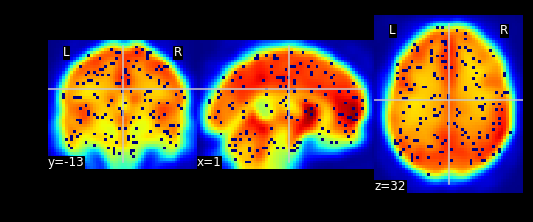

In [224]:
x_hat_image = plotting.plot_epi(image.index_img(x_hat_img,1), bg_img=None,black_bg=True, cmap='jet', cut_coords=None) 

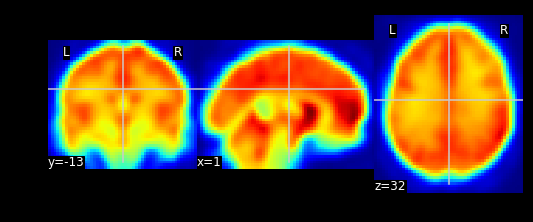

In [152]:
x_miss_image = plotting.plot_epi(image.index_img(x_miss_img,1), bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

In [153]:
plotting.show()

In [66]:
x_miss_image.savefig("/work/tmp/1.png")

In [84]:
x_true_img

In [85]:
x_miss_img

In [95]:
sparse_observation.shape

(53, 63, 46, 144)

In [97]:
mask_indices.shape

(53, 63, 46, 144)

In [108]:
mask_indices.shape

(3339, 46, 144)

In [110]:
sparse_observation.shape

(3339, 46, 144)

In [111]:
x_miss_img

In [112]:
print x_miss_img

<class 'nibabel.nifti1.Nifti1Image'>
data shape (53, 63, 46, 144)
affine: 
[[  -3.    0.    0.   78.]
 [   0.    3.    0. -111.]
 [   0.    0.    3.  -51.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : 
db_name         : 
extents         : 0
session_error   : 0
regular         : 
dim_info        : 0
dim             : [  4  53  63  46 144   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  3.  3.  3.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : 
aux_file        : 
qform_code      : unknown
sform_code      : aligned


In [116]:
x_init.shape

(53, 63, 46, 144)

In [133]:
x_reconstr_init = mt.reconstruct2(x_init_tcs, ground_truth, mask_indices)
tsc_score_init = cst.tsc(x_reconstr_init, ground_truth, ten_ones, mask_indices)

In [134]:
tsc_score_init

nan

In [135]:
norm_x_init

2714.9417

In [186]:
def shrinkage_Lq(b, q, lam, L):
    if q == 0:
        x = b.copy()
        i1 = np.where(abs(b) <= np.sqrt(2 * lam / L))
        x[i1] = 0
    elif (q < 1) and (q > 0):
        max_iter = 20
        abs_tol = 0.00001
        x = np.zeros(len(b))
        beta = (L / (lam * q * (1 - q))) ** (1 / (q - 2))
        f1 = lam * q * beta ** (q - 1) + L * beta - L * abs(b)
        i0 = np.where(f1 < 0)
        if len(i0[0]) != 0:
            b_u = abs(b[i0])
            x_u = b_u.copy()
            for i in range(max_iter):
                deta_x = (lam * q * x_u ** (q - 1) + L * x_u - L * b_u) / (lam * q * (q - 1) * x_u ** (q - 2) + L)
                x_u = x_u - deta_x
                if np.linalg.norm(deta_x) < np.sqrt(len(x_u)) * abs_tol:
                    break
            x_u = x_u * np.sign(b[i0])
            i1 = np.where(L / 2 * b_u ** 2 - lam * abs(x_u) ** q - L / 2 * (x_u - b[i0]) ** 2 < 0)
            x_u[i1] = 0
            x[i0] = x_u
    elif q == 1:
        x = np.sign(b) * max(abs(b) - lam / L, 0)
    return x

In [190]:
def GLTC_Lq(dense_tensor, sparse_tensor, alpha, beta, q, maxiter, mask):
    dim0 = sparse_tensor.ndim
    dim1, dim2, dim3 = sparse_tensor.shape
    dim = np.array([dim1, dim2, dim3])
    binary_tensor = np.zeros((dim1, dim2, dim3))
    binary_tensor = mask.copy()
    tensor_hat = sparse_tensor.copy()
    
    X = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{X}} (n1*n2*3*d)
    Z = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{Z}} (n1*n2*3*d)
    T = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{T}} (n1*n2*3*d)
    for k in range(dim0):
        X[:, :, :, k] = tensor_hat
        Z[:, :, :, k] = tensor_hat
    
    D1 = np.zeros((dim1 - 1, dim1)) # (n1-1)-by-n1 adjacent smoothness matrix
    for i in range(dim1 - 1):
        D1[i, i] = -1
        D1[i, i + 1] = 1
    D2 = np.zeros((dim2 - 1, dim2)) # (n2-1)-by-n2 adjacent smoothness matrix
    for i in range(dim2 - 1):
        D2[i, i] = -1
        D2[i, i + 1] = 1
    
    L = 1.001 # Lipschitz constant / rho in our work
    
    for iters in range(maxiter):
        for k in range(dim0):
            u, s, v = np.linalg.svd(ten2mat(X[:, :, :, k] + T[:, :, :, k] / L, k), full_matrices = 0)
            s = shrinkage_Lq(s, q, alpha, L)
            pos = np.where(s < 0)
            s[pos] = 0
            Z[:, :, :, k] = mat2ten(np.matmul(np.matmul(u, np.diag(s)), v), dim, k)
            var = ten2mat(L * Z[:, :, :, k] - T[:, :, :, k], k)
            if k == 0:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D1.T, D1) + L * np.eye(dim1)), var), dim, k)
            elif k == 1:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D2.T, D2) + L * np.eye(dim2)), var), dim, k)
            else:
                var0 = Z[:, :, :, k] - T[:, :, :, k] / L
            X[:, :, :, k] = np.multiply(1 - binary_tensor, var0) + sparse_tensor
            
        tensor_hat = np.mean(X, axis = 3)
        u0, s0, v0 = np.linalg.svd(ten2mat(np.mean(Z, axis = 3), 0))
        print(np.round(s0[:10]))
        print()
        for k in range(dim0):
            T[:, :, :, k] = T[:, :, :, k] + L * (X[:, :, :, k] - Z[:, :, :, k])
            X[:, :, :, k] = tensor_hat.copy()

    return tensor_hat

In [117]:
alpha = 100
rho = 1.001
beta = 0.1 * rho
q = 0.5
maxiter = 100

In [231]:
x_hat = GLTC_Lq(ground_truth, sparse_observation, alpha, beta, q, maxiter, mask_indices)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
()
[0. 0. 0. 0. 0. 0. 0

In [292]:
rse = mt.relative_error(x_hat,ground_truth_reshaped)

In [293]:
rse

0.0016447345657125462

In [194]:
x_hat.shape

(3339, 46, 144)

In [290]:
x_hat_img = mt.reconstruct_image_affine_d(x_true_img, x_hat, d, x_true_data.shape)

In [234]:
x_miss_img = mt.reconstruct_image_affine_d(x_true_img, sparse_observation, d, x_true_data.shape)

In [198]:
print x_miss_img

<class 'nibabel.nifti1.Nifti1Image'>
data shape (53, 63, 46, 144)
affine: 
[[  -3.    0.    0.   78.]
 [   0.    3.    0. -111.]
 [   0.    0.    3.  -51.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : 
db_name         : 
extents         : 0
session_error   : 0
regular         : 
dim_info        : 0
dim             : [  4  53  63  46 144   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  3.  3.  3.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : 
aux_file        : 
qform_code      : unknown
sform_code      : aligned


In [200]:
print ground_truth_img

<class 'nibabel.nifti1.Nifti1Image'>
data shape (3339, 46, 144)
affine: 
[[  -3.    0.    0.   78.]
 [   0.    3.    0. -111.]
 [   0.    0.    3.  -51.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : 
db_name         : 
extents         : 0
session_error   : 0
regular         : 
dim_info        : 0
dim             : [   3 3339   46  144    1    1    1    1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  3.  3.  3.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : 
aux_file        : 
qform_code      : unknown
sform_code      : al

In [291]:
mrd.draw_original_vs_reconstructed_rim_z_score(image.index_img(x_true_img, 143), image.index_img(x_hat_img,143), image.index_img(x_miss_img, 143), "",
                    0, 0.9, 0, 0, 2, coord=None, folder="/work/tmp", iteration = -1, time=143)
        

Missing Ratio Str:10.00%
Iteration: -1
('Saving figure', '/work/tmp/missing_ratio_10.00_timepoint_143.png')
Called from mrd


In [208]:
observed_ratio = 0.9
subject_scan_path = du.get_full_path_subject1()
x_true_img = mt.read_image_abs_path(subject_scan_path)
x_true_data = np.array(x_true_img.get_data())
x_true_reshaped = copy.deepcopy(x_true_data)
x_true_copy = copy.deepcopy(x_true_data)    
mask_indices = tu.get_mask_with_epi(x_true_data, x_true_img, observed_ratio, 4)
ground_truth, norm_ground_truth = tu.normalize_data(x_true_data)                
ground_truth_img = mt.reconstruct_image_affine(x_true_img, ground_truth)
sparse_observation = tu.create_sparse_observation(ground_truth, mask_indices)
sparse_observation[mask_indices == 0] = 0.0

In [ ]:
def mcp(x,theta, lam):
    x = np.abs(x)
    y[ind] = np.zeros_like(x)
    ind = np.where(x>theta*lam)
    y[ind] = theta*lam**2*0.5
    ind = np.where(x<=theta*lam)
    #print ind
    #print y
    if y == 0.0:
        return 0
    y[ind] = lam*x[ind]-x[ind]**2/(2*theta)
    return y

In [50]:
def mcp_np(x,theta, lam):
    G = 0
    for k in range(x.shape[2]):
        u, s, v = np.linalg.svd(x[:,:,k], full_matrices = 0)
        for sigma in s:
            G = G + mcp(sigma,theta, lam)
    return G

In [64]:
def mcp_sg(x,theta, lam):
    x = np.abs(x)
    y = np.zeros_like(x)
    print (y.shape)
    ind = np.where(x<theta*lam)
    y[ind] = lam-x[ind]/theta
    return y

In [36]:
def mcp_svt(img,theta, lam):
    u, s, v = np.linalg.svd(img, full_matrices = 0)
    th = mcp_sg(s,theta, lam)
    s = s - th
    s[s < 0] = 0
    X_hat = np.matmul(np.matmul(u, np.diag(s)), v)
    return X_hat

In [102]:
 def log_f(x,theta, lam):
    x = np.abs(x)
    y = lam*np.log(theta*x+1)/np.log(theta+1)
    return y

In [94]:
def log_sg(x,theta, lam):
    x = np.abs(x)
    y = lam*theta/((theta*x+1)*np.log(theta+1))
    return y

In [101]:
def log_p(x,theta, lam):
    G = 0
    for k in range(x.shape[2]):
        u, s, v = np.linalg.svd(x[:,:,k], full_matrices = 0)
        for sigma in s:
            G = G + log_f(sigma,theta, lam)
    return G

In [85]:
def log_svt(img,theta, lam):
    u, s, v = np.linalg.svd(img, full_matrices = 0)
    th = log_sg(s,theta, lam)
    s = s - th
    s[s < 0] = 0
    X_hat = np.matmul(np.matmul(u, np.diag(s)), v)
    return X_hat

In [1]:
def scad_sg(self, x,theta, lam):
    x = np.abs(x)
    y = np.zeros_like(x)
    ind = np.where(x <= lam)
    y[ind] = lam
    ind = np.where(np.logical_and((x > lam),(x <= theta*lam)))
    y[ind] = (theta*lam - x[ind])/(theta**2 - 1)
    return y

In [118]:
# German
theta = 2
alpha = 1000
rho = 0.01
beta = 0.1 * rho
maxiter = 50

In [256]:
def gemanp(img, alpha, theta):
    G = 0
    for k in range(img.shape[2]):
        u, s, v = np.linalg.svd(img[:,:,k], full_matrices = 0)
        for sigma in s:
            G = G + alpha * sigma / (sigma + theta)
    return G

In [257]:
def gsvt_geman(X, alpha, theta, rho):
    u, s, v = np.linalg.svd(X, full_matrices = 0)
    th = rho * alpha * theta / (alpha + theta) ** 2
    s = s - th
    s[s < 0] = 0
    X_hat = np.matmul(np.matmul(u, np.diag(s)), v)
    return X_hat

In [294]:
def supergradient(s_hat, lambda0, theta):
    """Supergradient of the Geman function."""
    return (lambda0 * theta / (s_hat + theta) ** 2)

def GLTC_Geman(dense_tensor, sparse_tensor, alpha, beta, rho, theta, maxiter, mask):
    """Main function of the GLTC-Geman."""
    dim0 = sparse_tensor.ndim
    dim1, dim2, dim3 = sparse_tensor.shape
    dim = np.array([dim1, dim2, dim3])
    binary_tensor = mask.copy()
    #binary_tensor[np.where(sparse_tensor != 0)] = 1
    tensor_hat = sparse_tensor.copy()
    
    X = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{X}} (n1*n2*3*d)
    Z = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{Z}} (n1*n2*3*d)
    T = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{T}} (n1*n2*3*d)
    for k in range(dim0):
        X[:, :, :, k] = tensor_hat
        Z[:, :, :, k] = tensor_hat
    
    D1 = np.zeros((dim1 - 1, dim1)) # (n1-1)-by-n1 adjacent smoothness matrix
    for i in range(dim1 - 1):
        D1[i, i] = -1
        D1[i, i + 1] = 1
    D2 = np.zeros((dim2 - 1, dim2)) # (n2-1)-by-n2 adjacent smoothness matrix
    for i in range(dim2 - 1):
        D2[i, i] = -1
        D2[i, i + 1] = 1
    pos = np.where((dense_tensor != 0) & (sparse_tensor == 0))    
    rankp = np.zeros(maxiter)
    rse = np.zeros(maxiter)
    for iters in range(maxiter):
        for k in range(dim0):
            Z_hat = ten2mat(X[:, :, :, k] + T[:, :, :, k] / rho, k)
            Z_hat = gsvt_geman(Z_hat, alpha, theta, rho)
            Z[:, :, :, k] = mat2ten(Z_hat, dim, k)
            var = ten2mat(rho * Z[:, :, :, k] - T[:, :, :, k], k)
            if k == 0:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D1.T, D1) + rho * np.eye(dim1)), var), dim, k)
            elif k == 1:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D2.T, D2) + rho * np.eye(dim2)), var), dim, k)
            else:
                var0 = Z[:, :, :, k] - T[:, :, :, k] / rho
            X[:, :, :, k] = np.multiply(1 - binary_tensor, var0) + sparse_tensor
        tensor_hat = np.mean(X, axis = 3)
        #tensor_hat[np.where(tensor_hat > 255)] = 255
        #tensor_hat[np.where(tensor_hat < 0)] = 0
        rse[iters] = mt.relative_error(tensor_hat,ground_truth_reshaped)
        #rse[iters] = np.linalg.norm(np.round(tensor_hat[pos]) - np.round(dense_tensor[pos]), 2) / np.linalg.norm(np.round(dense_tensor[pos]), 2)
        rankp[iters] = gemanp(tensor_hat, alpha, theta)
        print ("iters=" + str(iters) + "; " + str(rse[iters]) + "rank penalty= " + str(rankp[iters]))   
        for k in range(dim0):
            T[:, :, :, k] = T[:, :, :, k] + rho * (X[:, :, :, k] - Z[:, :, :, k])
            X[:, :, :, k] = tensor_hat.copy()
        
    return tensor_hat, rankp, rse

In [296]:
x_hat, rankp, rse = GLTC_Geman(ground_truth, sparse_observation, alpha, beta, rho, theta,maxiter, mask_indices)

iters=0; 0.27379542640626664rank penalty= 17143.164214839944
iters=1; 0.24830265503388063rank penalty= 16389.969010005094
iters=2; 0.2252827605241991rank penalty= 15715.191694129371
iters=3; 0.20448812712642145rank penalty= 15110.543075852182
iters=4; 0.18569639123382675rank penalty= 14568.612601263207
iters=5; 0.1687078365605466rank penalty= 14082.776183480193
iters=6; 0.1533430629387638rank penalty= 13647.113745577844
iters=7; 0.13944089758647862rank penalty= 13256.33529944369
iters=8; 0.12685652326936878rank penalty= 12905.714617281963
iters=9; 0.11545980055061625rank penalty= 12591.029690038504
iters=10; 0.1051337637691993rank penalty= 12308.50927805169
iters=11; 0.09577327255599062rank penalty= 12054.78494720343
iters=12; 0.08728380263463292rank penalty= 11826.848052769183
iters=13; 0.07958036137648698rank penalty= 11622.011189174058
iters=14; 0.07258651511789674rank penalty= 11437.87367082915
iters=15; 0.06623351661874226rank penalty= 11272.290650122057
iters=16; 0.06045952226660

In [288]:
rse

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

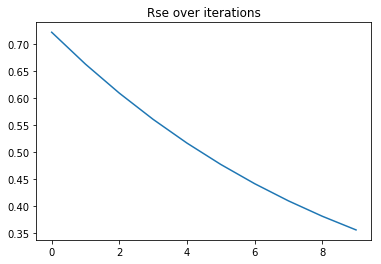

In [299]:

plt.plot(100 * rse[40:])
plt.title('Rse over iterations')
plt.show()

In [275]:
hat.shape

(3339, 46, 144)

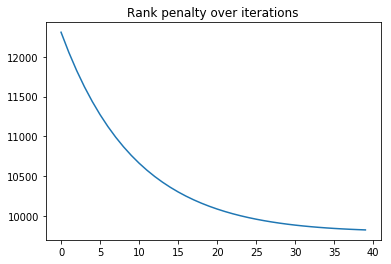

In [300]:
plt.plot(rankp[10:])
plt.title('Rank penalty over iterations')
plt.show()

In [278]:
rankp

array([17143.16421484, 16389.96901001, 15715.19169413, 15110.54307585,
       14568.61260126, 14082.77618348, 13647.11374558, 13256.33529944,
       12905.71461728, 12591.02969004, 12308.50927805, 12054.7849472 ,
       11826.84805277, 11622.01118917, 11437.87367083, 11272.29065012,
       11123.34551506, 10989.3252415 , 10868.69840376, 10760.09557284])

In [86]:

theta = 3
lam = 1.11
maxiter = 10
rho = 0.01
beta = 0.1 * rho

In [58]:
def GLTC_MCP(dense_tensor, sparse_tensor, theta, lam, maxiter, mask):
    """Main function of the GLTC-Geman."""
    dim0 = sparse_tensor.ndim
    dim1, dim2, dim3 = sparse_tensor.shape
    dim = np.array([dim1, dim2, dim3])
    binary_tensor = mask.copy()
    #binary_tensor[np.where(sparse_tensor != 0)] = 1
    tensor_hat = sparse_tensor.copy()
    
    X = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{X}} (n1*n2*3*d)
    Z = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{Z}} (n1*n2*3*d)
    T = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{T}} (n1*n2*3*d)
    for k in range(dim0):
        X[:, :, :, k] = tensor_hat
        Z[:, :, :, k] = tensor_hat
    
    D1 = np.zeros((dim1 - 1, dim1)) # (n1-1)-by-n1 adjacent smoothness matrix
    for i in range(dim1 - 1):
        D1[i, i] = -1
        D1[i, i + 1] = 1
    D2 = np.zeros((dim2 - 1, dim2)) # (n2-1)-by-n2 adjacent smoothness matrix
    for i in range(dim2 - 1):
        D2[i, i] = -1
        D2[i, i + 1] = 1
    pos = np.where((dense_tensor != 0) & (sparse_tensor == 0))    
    rankp = np.zeros(maxiter)
    rse = np.zeros(maxiter)
    for iters in range(maxiter):
        for k in range(dim0):
            Z_hat = ten2mat(X[:, :, :, k] + T[:, :, :, k] / rho, k)
            Z_hat = mcp_svt(Z_hat, theta, lam)
            Z[:, :, :, k] = mat2ten(Z_hat, dim, k)
            var = ten2mat(rho * Z[:, :, :, k] - T[:, :, :, k], k)
            if k == 0:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D1.T, D1) + rho * np.eye(dim1)), var), dim, k)
            elif k == 1:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D2.T, D2) + rho * np.eye(dim2)), var), dim, k)
            else:
                var0 = Z[:, :, :, k] - T[:, :, :, k] / rho
            X[:, :, :, k] = np.multiply(1 - binary_tensor, var0) + sparse_tensor
        tensor_hat = np.mean(X, axis = 3)
        #tensor_hat[np.where(tensor_hat > 255)] = 255
        #tensor_hat[np.where(tensor_hat < 0)] = 0
        rse[iters] = mt.relative_error(tensor_hat,ground_truth)
        #rse[iters] = np.linalg.norm(np.round(tensor_hat[pos]) - np.round(dense_tensor[pos]), 2) / np.linalg.norm(np.round(dense_tensor[pos]), 2)
        rankp[iters] = mcp_np(tensor_hat, theta, lam )
        print ("iters=" + str(iters) + "; " + str(rse[iters]) + "rank penalty= " + str(rankp[iters]))   
        for k in range(dim0):
            T[:, :, :, k] = T[:, :, :, k] + rho * (X[:, :, :, k] - Z[:, :, :, k])
            X[:, :, :, k] = tensor_hat.copy()
        
    return tensor_hat, rankp, rse

In [70]:
x_hat, rankp, rse = GLTC_MCP(ground_truth, sparse_observation, theta, lam, maxiter, mask_indices)

(3339,)
(46,)
(144,)
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array(

0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array

(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]

(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]

(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]

(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]

(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]

0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array

(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]

(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]

0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array

(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]

0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array

(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]

(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]

(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]

(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]

(3339,)
(46,)
(144,)
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array(

(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]

0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array

(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]

(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]

(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]

(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]

(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]

(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]),)
0.0
(array([0]

KeyboardInterrupt: 

In [43]:
ground_truth.shape

(3339, 46, 144)

In [103]:
def GLTC_LOG(dense_tensor, sparse_tensor, theta, lam, maxiter, mask):
    """Main function of the GLTC-Geman."""
    dim0 = sparse_tensor.ndim
    dim1, dim2, dim3 = sparse_tensor.shape
    dim = np.array([dim1, dim2, dim3])
    binary_tensor = mask.copy()
    #binary_tensor[np.where(sparse_tensor != 0)] = 1
    tensor_hat = sparse_tensor.copy()
    
    X = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{X}} (n1*n2*3*d)
    Z = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{Z}} (n1*n2*3*d)
    T = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{T}} (n1*n2*3*d)
    for k in range(dim0):
        X[:, :, :, k] = tensor_hat
        Z[:, :, :, k] = tensor_hat
    
    D1 = np.zeros((dim1 - 1, dim1)) # (n1-1)-by-n1 adjacent smoothness matrix
    for i in range(dim1 - 1):
        D1[i, i] = -1
        D1[i, i + 1] = 1
    D2 = np.zeros((dim2 - 1, dim2)) # (n2-1)-by-n2 adjacent smoothness matrix
    for i in range(dim2 - 1):
        D2[i, i] = -1
        D2[i, i + 1] = 1
    pos = np.where((dense_tensor != 0) & (sparse_tensor == 0))    
    rankp = np.zeros(maxiter)
    rse = np.zeros(maxiter)
    for iters in range(maxiter):
        for k in range(dim0):
            Z_hat = ten2mat(X[:, :, :, k] + T[:, :, :, k] / rho, k)
            Z_hat = log_svt(Z_hat, theta, lam)
            Z[:, :, :, k] = mat2ten(Z_hat, dim, k)
            var = ten2mat(rho * Z[:, :, :, k] - T[:, :, :, k], k)
            if k == 0:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D1.T, D1) + rho * np.eye(dim1)), var), dim, k)
            elif k == 1:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D2.T, D2) + rho * np.eye(dim2)), var), dim, k)
            else:
                var0 = Z[:, :, :, k] - T[:, :, :, k] / rho
            X[:, :, :, k] = np.multiply(1 - binary_tensor, var0) + sparse_tensor
        tensor_hat = np.mean(X, axis = 3)
        #tensor_hat[np.where(tensor_hat > 255)] = 255
        #tensor_hat[np.where(tensor_hat < 0)] = 0
        rse[iters] = mt.relative_error(tensor_hat,ground_truth)
        #rse[iters] = np.linalg.norm(np.round(tensor_hat[pos]) - np.round(dense_tensor[pos]), 2) / np.linalg.norm(np.round(dense_tensor[pos]), 2)
        rankp[iters] = log_p(tensor_hat, theta, lam )
        print ("iters=" + str(iters) + "; " + str(rse[iters]) + "rank penalty= " + str(rankp[iters]))   
        for k in range(dim0):
            T[:, :, :, k] = T[:, :, :, k] + rho * (X[:, :, :, k] - Z[:, :, :, k])
            X[:, :, :, k] = tensor_hat.copy()
        
    return tensor_hat, rankp, rse

In [104]:
x_hat, rankp, rse = GLTC_LOG(ground_truth, sparse_observation, theta, lam, maxiter, mask_indices)

iters=0; 0.2361585563083199rank penalty= 75.29100338752129
iters=1; 0.045851488670960464rank penalty= 49.95086559080777
iters=2; 0.048170684050427535rank penalty= 50.06213634637899
iters=3; 0.04597551558167227rank penalty= 49.67422583030584
iters=4; 0.03178375425267879rank penalty= 48.219889085293396
iters=5; 0.031012559272543063rank penalty= 48.10584051545513
iters=6; 0.02562599464939545rank penalty= 47.433282564656096
iters=7; 0.025417520324733742rank penalty= 47.398764361358765
iters=8; 0.018255349856282667rank penalty= 46.684029145955805
iters=9; 0.018013322167602666rank penalty= 46.62921127747309


In [119]:
def rankpenalty_tnn(img, alpha, theta):
    P = 0
    count = 0
    for k in range(img.shape[2]):
        u, s, v = np.linalg.svd(img[:,:,k], full_matrices = 0)
        for sigma in s:
            P += sigma
            if sigma > 1:
                count += 1
    return P, count

def svt_tnn(mat, tau, theta):
    u, s, v = np.linalg.svd(mat, full_matrices = 0)
    vec = np.zeros(len(s))
    for i in range(len(s)):
        if i >= theta:
            vec[i] = s[i] - tau
        else:
            vec[i] = s[i]
    vec[vec < 0] = 0
    return np.matmul(np.matmul(u, np.diag(vec)), v)

def GLTC_TNN(dense_tensor, sparse_tensor, alpha, beta, rho, theta, maxiter, mask, validation = 1):
    """Main function of the GLTC-Geman."""
    dim0 = sparse_tensor.ndim
    dim1, dim2, dim3 = sparse_tensor.shape
    dim = np.array([dim1, dim2, dim3])
    binary_tensor = np.zeros((dim1, dim2, dim3))
    binary_tensor = mask.copy()
    tensor_hat = sparse_tensor.copy()
    
    X = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{X}} (n1*n2*3*d)
    Z = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{Z}} (n1*n2*3*d)
    T = np.zeros((dim1, dim2, dim3, dim0)) # \boldsymbol{\mathcal{T}} (n1*n2*3*d)
    for k in range(dim0):
        X[:, :, :, k] = tensor_hat
        Z[:, :, :, k] = tensor_hat
    
    D1 = np.zeros((dim1 - 1, dim1)) # (n1-1)-by-n1 adjacent smoothness matrix
    for i in range(dim1 - 1):
        D1[i, i] = -1
        D1[i, i + 1] = 1
    D2 = np.zeros((dim2 - 1, dim2)) # (n2-1)-by-n2 adjacent smoothness matrix
    for i in range(dim2 - 1):
        D2[i, i] = -1
        D2[i, i + 1] = 1
    pos = np.where((dense_tensor != 0) & (sparse_tensor == 0))    
    rankp = np.zeros(maxiter)
    rse = np.zeros(maxiter)
    count = np.zeros(maxiter)
    for iters in range(maxiter):
        for k in range(dim0):
            Z_hat = ten2mat(X[:, :, :, k] + T[:, :, :, k] / rho, k)
            Z_hat = svt_tnn(Z_hat, alpha / rho, theta)
            Z[:, :, :, k] = mat2ten(Z_hat, dim, k)
            var = ten2mat(rho * Z[:, :, :, k] - T[:, :, :, k], k)
            if k == 0:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D1.T, D1) + rho * np.eye(dim1)), var), dim, k)
            elif k == 1:
                var0 = mat2ten(np.matmul(inv(beta * np.matmul(D2.T, D2) + rho * np.eye(dim2)), var), dim, k)
            else:
                var0 = Z[:, :, :, k] - T[:, :, :, k] / rho
            X[:, :, :, k] = np.multiply(1 - binary_tensor, var0) + sparse_tensor
        tensor_hat = np.mean(X, axis = 3)
        if validation:
            #tensor_hat[np.where(tensor_hat > 255)] = 255
            #tensor_hat[np.where(tensor_hat < 0)] = 0
            #rse[iters] = np.linalg.norm(np.round(tensor_hat[pos]) - np.round(dense_tensor[pos]), 2) / np.linalg.norm(np.round(dense_tensor[pos]), 2)
            rse[iters] = mt.relative_error(tensor_hat,ground_truth)
            rankp[iters], count[iters] = rankpenalty_tnn(tensor_hat, alpha, theta)
            print ("iters=" + str(iters) + "; " + str(rse[iters]) + "rank penalty= " + str(rankp[iters]))   
        for k in range(dim0):
            T[:, :, :, k] = T[:, :, :, k] + rho * (X[:, :, :, k] - Z[:, :, :, k])
            X[:, :, :, k] = tensor_hat.copy()
    if validation:
        return tensor_hat, rse, rankp, count
    else:
        return tensor_hat

In [120]:
x_hat, rankp, rse = GLTC_TNN(ground_truth, sparse_observation, alpha, beta, rho, theta, maxiter, mask_indices, validation = 1)

iters=0; 0.047973917979080925rank penalty= 22.13065541587797
iters=1; 0.043000681828377955rank penalty= 21.986333770517984
iters=2; 0.03763536504917881rank penalty= 21.767530071580165
iters=3; 0.04979613715574438rank penalty= 22.40381573237177
iters=4; 0.0354182892590678rank penalty= 21.659546241537434
iters=5; 0.05089828825315376rank penalty= 22.460636568142952
iters=6; 0.03634105077954149rank penalty= 21.654280449662725
iters=7; 0.06437038482097308rank penalty= 23.237511811655114
iters=8; 0.06875315836170082rank penalty= 23.420043699050137
iters=9; 0.05277099003163198rank penalty= 22.60830296991125
iters=10; 0.06325253744427381rank penalty= 23.07191438227484
iters=11; 0.0825121555514994rank penalty= 24.25846337570698
iters=12; 0.06104612996617511rank penalty= 23.060634781737736
iters=13; 0.07926933671150688rank penalty= 24.003840890958955
iters=14; 0.08214373378119091rank penalty= 24.2139183829481
iters=15; 0.07337894099312814rank penalty= 23.717499092511044
iters=16; 0.0741532093681

ValueError: too many values to unpack

In [122]:
rank_p_df = pd.DataFrame(rankp) 
file_name = "/work/tmp/tnn_rank_penalty.csv"